In [ ]:
import numpy as np

data = np.load("data.npy")

batch_size_num = int(2048*2)

In [ ]:
import torch
torch.set_num_threads(8)  
torch.set_num_interop_threads(2)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.notebook import trange


def compute_energy(F_i, F_total):

    # if F_total == 0 or F_i == 0:
    #     return 0.0  
    
    # E_nu_i = abs(70 - 60 * torch.sqrt(F_i / F_total))
    E_nu_i = 70 - 60 * torch.sqrt(F_i / F_total)   

    if E_nu_i < 0:
        return 0.0
    elif E_nu_i > 60:
        return 60.0
    else:
        return E_nu_i




X = torch.tensor(data[:, :9], dtype=torch.float64)  
y_main = torch.tensor(data[:, 9:17], dtype=torch.float64)  



F_nue_total = torch.tensor(data[:, 1], dtype=torch.float64)  
F_nue_i = torch.tensor(data[:, 4], dtype=torch.float64)  

F_nueb_total = torch.tensor(data[:, 2], dtype=torch.float64)  
F_nueb_i = torch.tensor(data[:, 6], dtype=torch.float64)  


E_nue_i_ori = torch.tensor(
    [compute_energy(F_nue_i[i], F_nue_total[i]) for i in range(len(F_nue_i))],
    dtype=torch.float64
).unsqueeze(1)

E_nueb_i_ori = torch.tensor(
    [compute_energy(F_nueb_i[i], F_nueb_total[i]) for i in range(len(F_nueb_i))],
    dtype=torch.float64
).unsqueeze(1)

mask = (E_nue_i_ori.squeeze(1) >= 0) & (E_nueb_i_ori.squeeze(1) >= 0)

E_nue_i_ori = E_nue_i_ori[mask]
E_nueb_i_ori = E_nueb_i_ori[mask]


E_nue_i = torch.tensor([compute_energy(F_nue_i[i], F_nue_total[i]) for i in range(len(F_nue_i))], dtype=torch.float64)[mask]
E_nue_i = E_nue_i * torch.tensor(data[:, 3][mask], dtype=torch.float64) 
E_nue_i = E_nue_i.unsqueeze(1) 


E_nueb_i = torch.tensor([compute_energy(F_nueb_i[i], F_nueb_total[i]) for i in range(len(F_nueb_i))], dtype=torch.float64)[mask]
E_nueb_i = E_nueb_i * torch.tensor(data[:, 5][mask], dtype=torch.float64)
E_nueb_i = E_nueb_i.unsqueeze(1)  

X = X[mask]
y_main = y_main[mask]

X = torch.cat([X,E_nue_i_ori,E_nueb_i_ori], dim=1)

# y_reg = torch.tensor(data[:, 17:20], dtype=torch.float64)  
E_all = torch.tensor([compute_energy(F_nue_i[i], F_nue_total[i]) for i in range(len(F_nue_i))], dtype=torch.float64)[mask]






In [ ]:

device = torch.device("cuda")



In [ ]:
def compute_correlation_matrix(X: torch.Tensor, Y: torch.Tensor):

    X_centered = X - X.mean(dim=0, keepdim=True)
    Y_centered = Y - Y.mean(dim=0, keepdim=True)


    numerator = torch.matmul(X_centered.T, Y_centered) / X.shape[0]  


    X_std = X.std(dim=0, unbiased=False).unsqueeze(1)  # [input_dim, 1]
    Y_std = Y.std(dim=0, unbiased=False).unsqueeze(0)  # [1, output_dim]

    corr_matrix = numerator / (X_std @ Y_std + 1e-8)  
    return corr_matrix


In [ ]:
def correlation_regularization(X, Y_pred, prior_corr_matrix):

    curr_corr = compute_correlation_matrix(X, Y_pred)
    diff = (curr_corr - prior_corr_matrix.to(X.device)) ** 2
    return torch.mean(diff)


In [ ]:
import torch
from scipy.signal import fftconvolve

def autocorr_loss(pred, target, x_input, return_detail=False):

    losses = {}
    B = pred.shape[0]


    group1 = [0,4]  
    group2 = [2,6]  

    for i in group1:
        sort_idx = torch.argsort(x_input[:, -2])
        pred_sorted = pred[sort_idx, i].detach().cpu()
        targ_sorted = target[sort_idx, i].detach().cpu()

        pred_conv = fftconvolve(pred_sorted, pred_sorted, mode='same')
        targ_conv = fftconvolve(targ_sorted, targ_sorted, mode='same')

        loss_i = torch.mean((torch.tensor(pred_conv) - torch.tensor(targ_conv)) ** 2)
        losses[f'ch_{i}'] = loss_i

    for i in group2:
        sort_idx = torch.argsort(x_input[:, -1])
        pred_sorted = pred[sort_idx, i].detach().cpu()
        targ_sorted = target[sort_idx, i].detach().cpu()

        pred_conv = fftconvolve(pred_sorted, pred_sorted, mode='same')
        targ_conv = fftconvolve(targ_sorted, targ_sorted, mode='same')

        loss_i = torch.mean((torch.tensor(pred_conv) - torch.tensor(targ_conv)) ** 2)
        losses[f'ch_{i}'] = loss_i

    # total_loss = torch.stack(list(losses.values())).mean()
    loss_tensor = torch.stack(list(losses.values()))
    loss_tensor = (loss_tensor - loss_tensor.min()) / (loss_tensor.max() - loss_tensor.min() + 1e-8)
    total_loss = loss_tensor.mean()



    return (total_loss, losses) if return_detail else total_loss


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LossMixer(nn.Module):
    def __init__(self, num_losses=3):
        super().__init__()
        self.raw_weights = nn.Parameter(torch.ones(num_losses))

    def forward(self, losses):
        loss_tensor = torch.stack(losses)  # shape: [4]
        norm_weights = F.softmax(self.raw_weights, dim=0)  # shape: [4]
        total_loss = torch.sum(norm_weights * loss_tensor)  
        return total_loss, norm_weights.detach()


loss_mixer = LossMixer(num_losses=3).to(device)

In [ ]:
def custom_criterion(main_output, target_main, input_x):

    channel_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 
                                  device=main_output.device)
    norm_weights = channel_weights / channel_weights.sum()
    

    base_loss_per_channel = torch.mean((main_output - target_main) ** 2, dim=0) 
    base_loss = torch.sum(norm_weights * base_loss_per_channel)
    

    a_nue_e = input_x[:,-2]*main_output[:,0] - input_x[:,-1]*main_output[:,2]
    a_nue_x = input_x[:,-2]*main_output[:,4] - input_x[:,-1]*main_output[:,6]
    
    a_nue_e_target = input_x[:,-2]*target_main[:,0] - input_x[:,-1]*target_main[:,2]
    a_nue_x_target = input_x[:,-2]*target_main[:,4] - input_x[:,-1]*target_main[:,6]
    
    l_extra1 = F.mse_loss(a_nue_e, a_nue_e_target)
    l_extra2 = F.mse_loss(a_nue_x, a_nue_x_target)
    l_extra3 = F.mse_loss(a_nue_x.mean(), a_nue_x_target.mean())
    

    # bath_corr_matrix = compute_correlation_matrix(input_x, target_main)
    # struct_loss = correlation_regularization(input_x, main_output, bath_corr_matrix)
    

    total_loss, _ = loss_mixer([
        l_extra1,
        l_extra2,
        l_extra3
        # struct_loss
    ])
    
    return 0.1 * total_loss + 0.9 * base_loss

In [ ]:

# dims_to_remove = [0]  # 


# keep_dims = [i for i in range(X.size(1)) if i not in dims_to_remove]

# X_filtered = X[:, keep_dims]


X_filtered = X


train_size = int(0.8 * len(X_filtered))
# X_mean = X_filtered.mean(dim=0)
# X_std = X_filtered.std(dim=0)


# # X_norm = (X_filtered - X_mean) / X_std
# X_norm = X_filtered  


train_X = X_filtered[:train_size]
val_X = X_filtered[train_size:]


train_y_main, val_y_main = y_main[:train_size], y_main[train_size:]


train_dataset = TensorDataset(train_X, train_y_main)
val_dataset = TensorDataset(val_X, val_y_main)



train_loader = DataLoader(train_dataset, batch_size=batch_size_num,shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size_num, shuffle=False, num_workers=6)






In [ ]:
from kan import *


class PINN(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=150, output_dim=4, reg_dim=3):
        super(PINN, self).__init__()
        

        self.output = KAN(width=[11, 4 ,8], grid=5, k=5,base_fun=torch.nn.Tanh(),ckpt_path='/model')
        


    def forward(self, x):


        main_output = self.output(x)


        
        return main_output

In [ ]:

                                                                              
train_losses = []
val_losses = []

pinn_rel_error_epoch = 0.0
pinn_nu_error_epoch = 0.0
total_samples = 0
best_rel_error = float('inf')
best_model_path = 'best_model.pth'  
pinn_errors = []        
pinn_nu_errors = []      

model = PINN().to(device).double()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)




checkpoint directory created: /model
saving model version 0.0


In [ ]:
def adjust_lr_by_gradient(optimizer, model, base_lr=1e-3, max_norm=500.0):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)  # L2 norm
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5


    new_lr = base_lr
    if total_norm > max_norm:
        new_lr = base_lr * (max_norm / total_norm)  
    elif total_norm < 1e2:
        new_lr = base_lr * 2  

    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

    return total_norm, new_lr


In [ ]:
from tqdm.notebook import trange, tqdm




best_total_delta = float('inf')
best_rel_error = float('inf')





num_epochs = 300


adam_optimizer = torch.optim.Adam(
    list(model.parameters()) + list(loss_mixer.parameters()), 
    lr=3e-3)


lbfgs_optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=0.1,          
    max_iter=20,     
    history_size=10  
)

threshold_epoch = int(300)  

for epoch in trange(num_epochs, desc="Training"):
    running_loss = 0.0
    use_lbfgs = (epoch >= threshold_epoch)
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        if not use_lbfgs:
            # --------- Adam ----------
            adam_optimizer.zero_grad()
            outputs = model(batch_X)
            loss = custom_criterion(outputs, batch_y, batch_X)

            loss.backward()
            adam_optimizer.step()

        else:
            # —— L-BFGS —— 
            def closure():
                lbfgs_optimizer.zero_grad()
                outputs = model(batch_X)
                loss = custom_criterion(outputs, batch_y, batch_X)
                loss.backward()
                return loss

            loss = lbfgs_optimizer.step(closure)

        running_loss += loss.item()


    train_losses.append(running_loss / len(train_loader))

    val_loss = 0.0
    pinn_rel_error_epoch = 0.0  
    pinn_nu_error_epoch = 0.0






    with torch.no_grad():

        for val_X_batch, val_y_main_batch in val_loader:
            val_X_batch, val_y_main_batch = val_X_batch.to(device), val_y_main_batch.to(device)
            val_outputs_main = model(val_X_batch)

            batch_rel_error = torch.mean(torch.abs(val_outputs_main - val_y_main_batch) /
                                        (torch.abs(val_y_main_batch) + 1e-8)).item()
            val_loss += custom_criterion(val_outputs_main, val_y_main_batch,  val_X_batch).item()

            # weights = torch.tensor([0.8, 0.8, (18.2 * 1e6) , (18.2 * 1e6)])
            weights = torch.tensor([1, 1, 1 , 1])
            norm_weights = weights / weights.sum()
            pred_nue_sum = norm_weights[0] * val_outputs_main[:, 0] + norm_weights[1] *val_outputs_main[:, 2] + norm_weights[2]* val_outputs_main[:, 4]+ norm_weights[3] * val_outputs_main[:, 6]
            
            true_nue_sum = norm_weights[0] *val_y_main_batch[:, 0] + norm_weights[1] *val_y_main_batch[:, 2]+ norm_weights[2] *val_y_main_batch[:, 4] + norm_weights[3] * val_y_main_batch[:, 6]

            # pred_nue_sum = val_outputs_main[:, 0]
            # true_nue_sum = val_y_main_batch[:, 0]

            batch_nu_error = torch.mean(torch.abs(pred_nue_sum - true_nue_sum) /
                                        (torch.abs(true_nue_sum) + 1e-8)).item()

            # pred_nue_sum = val_outputs_main[:, 0]
            # true_nue_sum = val_y_main_batch[:, 0]

            batch_nu_error =torch.mean(torch.abs(pred_nue_sum - true_nue_sum) /
                                        (torch.abs(true_nue_sum) + 1e-8)).item()

            pinn_rel_error_epoch += batch_rel_error * len(val_X_batch)
            pinn_nu_error_epoch += batch_nu_error * len(val_X_batch)
            total_samples += len(val_X_batch)

    pinn_rel_error_epoch /= total_samples
    pinn_nu_error_epoch /= total_samples
    
    # 
    if pinn_rel_error_epoch < best_rel_error:
        best_rel_error = pinn_rel_error_epoch
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with Rel Error: {best_rel_error:.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}], "
            # f"Train Loss: {train_losses[-1]:.6f}, "
            # # f"Val Loss: {val_losses[-1]:.6f}, " 
            # f"Total Delta: {total_delta:.6f},"
            f"PINN Rel Error: {pinn_rel_error_epoch:.6f}, "
            f"PINN ν_e+ν̄_e Error: {pinn_nu_error_epoch:.6f},"
            f"train loss: {train_losses[-1]:.6f}"
            )


        pinn_errors.append(pinn_rel_error_epoch)
        pinn_nu_errors.append(pinn_nu_error_epoch)
        val_losses.append(val_loss / len(val_loader))

 

Training:   0%|          | 0/300 [00:00<?, ?it/s]

New best model saved with Rel Error: 4.8628
Epoch [1/300], PINN Rel Error: 4.862785, PINN ν_e+ν̄_e Error: 0.641611,train loss: 0.548818
New best model saved with Rel Error: 2.1122
Epoch [2/300], PINN Rel Error: 2.112210, PINN ν_e+ν̄_e Error: 0.288895,train loss: 0.145004
New best model saved with Rel Error: 1.5509
Epoch [3/300], PINN Rel Error: 1.550930, PINN ν_e+ν̄_e Error: 0.154989,train loss: 0.074364
New best model saved with Rel Error: 0.9326
Epoch [4/300], PINN Rel Error: 0.932596, PINN ν_e+ν̄_e Error: 0.071469,train loss: 0.043559
New best model saved with Rel Error: 0.7373
Epoch [5/300], PINN Rel Error: 0.737285, PINN ν_e+ν̄_e Error: 0.050950,train loss: 0.032650
New best model saved with Rel Error: 0.6156
Epoch [6/300], PINN Rel Error: 0.615637, PINN ν_e+ν̄_e Error: 0.038878,train loss: 0.028967
New best model saved with Rel Error: 0.5200
Epoch [7/300], PINN Rel Error: 0.520031, PINN ν_e+ν̄_e Error: 0.031083,train loss: 0.026413
New best model saved with Rel Error: 0.4508
Epoc

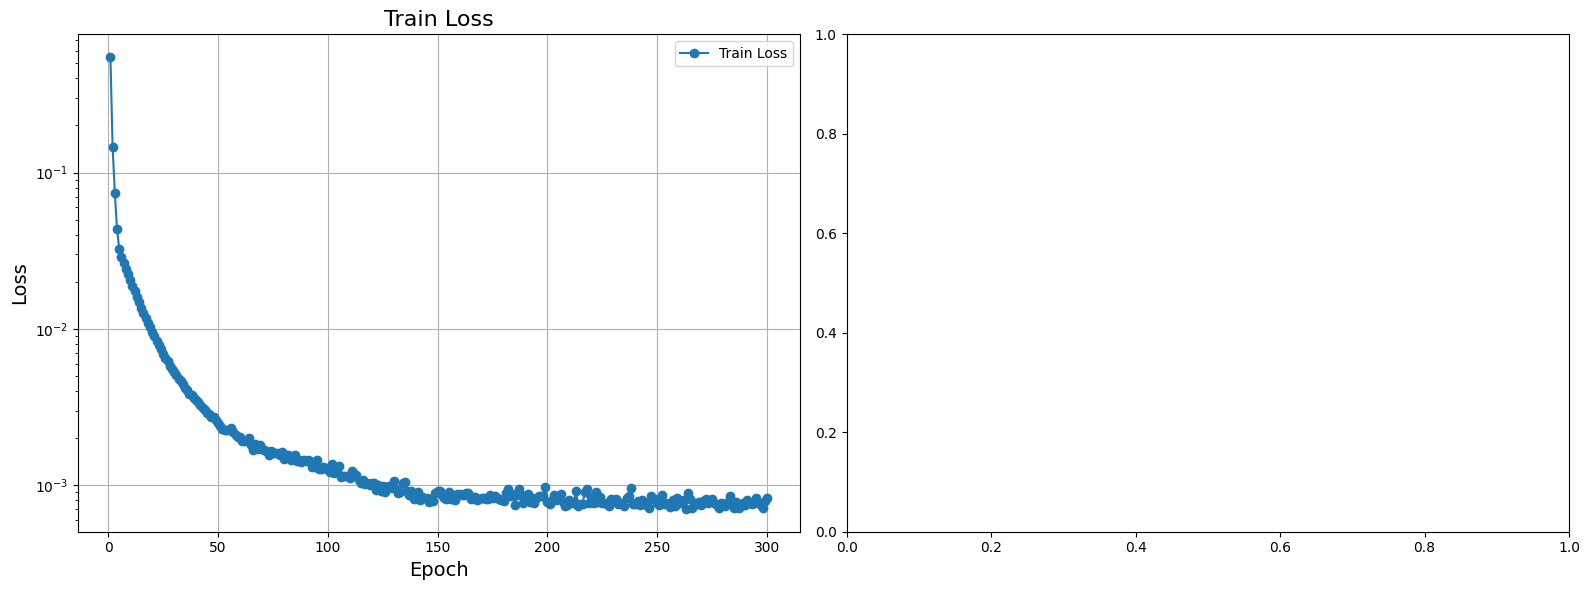

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))


axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o", linestyle="-")
axs[0].set_xlabel("Epoch", fontsize=14)
axs[0].set_ylabel("Loss", fontsize=14)
axs[0].set_title("Train Loss", fontsize=16)
axs[0].set_yscale('log')  
axs[0].grid(True)
axs[0].legend()



plt.tight_layout()
plt.show()

In [ ]:
import numpy as np


epochs_array = np.arange(num_epochs)



output_filename = 'training_metrics.txt'


header_text = 'Epoch\tpinn_errors\tpinn_nu_errors\ttrain_losses\tval_loss'


data_to_save = np.column_stack([epochs_array,
                               pinn_errors,
                               pinn_nu_errors,
                               train_losses,
                               val_losses])


np.savetxt(output_filename,
           data_to_save,
           fmt='%.6e',
           delimiter='\t',
           header=header_text,
           comments='# ') 

print(f"Already Save in '{output_filename}'")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "font.size": 14,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "axes.linewidth": 1.5,
    "xtick.major.width": 1.5,
    "ytick.major.width": 1.5,
    "xtick.direction": 'in',
    "ytick.direction": 'in',
    "xtick.top": True,
    "ytick.right": True,
    "text.usetex": True,
})


input_filename = 'training_metrics.txt'


epoch, pinn_err, pinn_nu_err, train_loss, val_loss = np.loadtxt(
    input_filename,
    unpack=True,
    delimiter='\t' 
)


fig, ax = plt.subplots(figsize=(8, 6))


ax.plot(epoch, train_loss, color='cyan', linestyle='-', label='Train Loss')
ax.plot(epoch, val_loss, color='magenta', linestyle='--', label='Validation Loss')
ax.plot(epoch, pinn_err, color='blue', linestyle=':', label='PINN Errors')
ax.plot(epoch, pinn_nu_err, color='orange', linestyle='-.', label=r'PINN $\nu$ Errors') # LaTeX in label


ax.set_yscale('log')


ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss / Relative Error')
ax.set_title(r'Training and Validation Metrics')


ax.set_xlim(left=0, right=len(epoch))


ax.legend(loc='upper right', frameon=True, edgecolor='black')


ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)


plt.tight_layout()


plt.savefig('training_metrics_plot.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [18]:
model.load_state_dict(torch.load(best_model_path))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_72612\3281425147.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

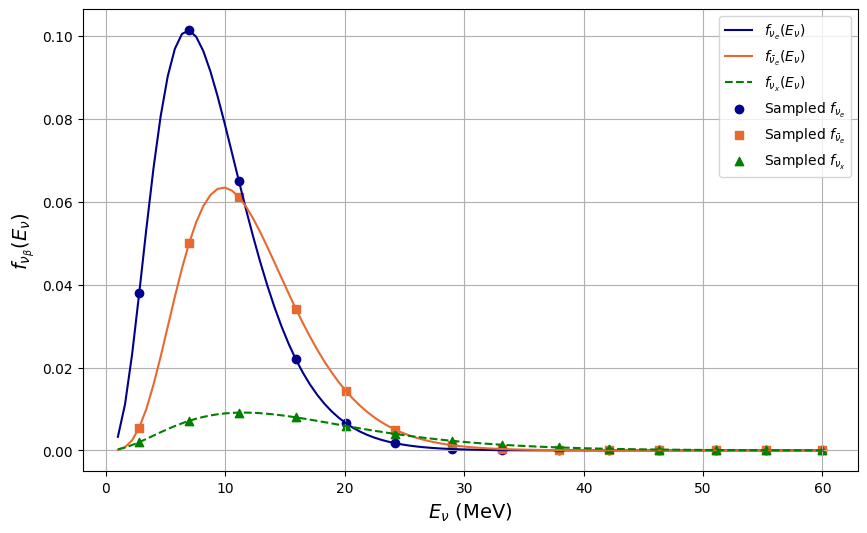

[[0.14504277101416002,
  0.5,
  0.7,
  0.0380195527056343,
  0.6274262830323437,
  0.005514461277144104,
  0.8783967962452812,
  0.0020042776874742594,
  1.0038820528517498,
  2.7878787878787876,
  2.7878787878787876],
 [0.493284214576731,
  0.5,
  0.7,
  0.10137114883594793,
  0.5519572974413042,
  0.050004787534281475,
  0.7727402164178259,
  0.007135435156490484,
  0.8831316759060868,
  6.959595959595959,
  6.959595959595959],
 [0.9404728231574233,
  0.5,
  0.7,
  0.06502926995008267,
  0.4813225407838203,
  0.06115826109782044,
  0.6738515570973485,
  0.009123955769767201,
  0.7701160652541126,
  11.13131313131313,
  11.13131313131313],
 [1.5555039612351378,
  0.5,
  0.7,
  0.02199248174729033,
  0.40651656860411073,
  0.034209392475301574,
  0.569123196045755,
  0.007982910054765624,
  0.6504265097665772,
  15.898989898989898,
  15.898989898989898],
 [2.180319555963289,
  0.5,
  0.7,
  0.00661617833740039,
  0.34624087394710285,
  0.01442538301477475,
  0.484737223525944,
  0.0059

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import pandas as pd


L_nu_e = 1
L_nu_bar_e = 1
L_nu_x = 0.33
E_nu_e_avg = 9
E_nu_bar_e_avg = 12
E_nu_x_avg = 16.5
n_nu_e = 3.2
n_nu_bar_e = 4.5
n_nu_x = 2.3


T_nu_e = E_nu_e_avg / (1 + n_nu_e)
T_nu_bar_e = E_nu_bar_e_avg / (1 + n_nu_bar_e)
T_nu_x = E_nu_x_avg / (1 + n_nu_x)


def f_nu(E_nu, T_nu, n_nu):
    return (1 / (T_nu * gamma(1 + n_nu))) * (E_nu / T_nu)**n_nu * np.exp(-E_nu / T_nu)


E_nu = np.linspace(1, 60, 100)


f_nu_e = f_nu(E_nu, T_nu_e, n_nu_e)
f_nu_bar_e = f_nu(E_nu, T_nu_bar_e, n_nu_bar_e) * ((E_nu_e_avg / E_nu_bar_e_avg) / (L_nu_e / L_nu_bar_e)) 
f_nu_x = f_nu(E_nu, T_nu_x, n_nu_x) * ((E_nu_e_avg / E_nu_x_avg) / (L_nu_e / L_nu_x))




num_points = 14
indices = np.linspace(3, len(E_nu)-1, num_points, dtype=int)
E_nu_sampled = E_nu[indices]
n_nue_sampled = f_nu_e[indices]
n_nueb_sampled = f_nu_bar_e[indices]
n_nux_sampled = f_nu_x[indices]



threshold_nue = 8e-9
threshold_nueb = 8e-9
threshold_nux = 8e-9

n_nue_sampled = np.maximum(n_nue_sampled, threshold_nue)
n_nueb_sampled = np.maximum(n_nueb_sampled, threshold_nueb)
n_nux_sampled = np.maximum(n_nux_sampled, threshold_nux)


F_nue_tot = 0.5
F_nueb_tot = 0.7
F_nux_tot = 0.8

F_nue_sampled = F_nue_tot * (70 - E_nu_sampled) ** 2 / 60 ** 2
F_nueb_sampled = F_nueb_tot * (70 - E_nu_sampled) ** 2 / 60 ** 2
F_nux_sampled = F_nux_tot * (70 - E_nu_sampled) ** 2 / 60 ** 2


alpha_sampled = n_nueb_sampled/ n_nue_sampled


plt.figure(figsize=(10, 6))
plt.plot(E_nu, f_nu_e, label=r'$f_{\nu_e}(E_\nu)$', color=(0, 0, 139/255), linestyle='-')
plt.plot(E_nu, f_nu_bar_e, label=r'$f_{\bar{\nu}_e}(E_\nu)$', color=(232/255, 105/255, 48/255), linestyle='-')
plt.plot(E_nu, f_nu_x, label=r'$f_{\nu_x}(E_\nu)$', color='green', linestyle='--')


plt.scatter(E_nu_sampled, n_nue_sampled, color=(0, 0, 139/255), marker='o', label=r'Sampled $f_{\nu_e}$')
plt.scatter(E_nu_sampled, n_nueb_sampled, color=(232/255, 105/255, 48/255), marker='s', label=r'Sampled $f_{\bar{\nu}_e}$')
plt.scatter(E_nu_sampled, n_nux_sampled, color='green', marker='^', label=r'Sampled $f_{\nu_x}$')


#plt.title(r"Neutrino Spectra with Sampled Points", fontsize=16)
plt.xlabel(r"$E_\nu$ (MeV)", fontsize=14)
plt.ylabel(r"$f_{\nu_\beta}(E_\nu)$", fontsize=14)
plt.legend(loc='best')
plt.grid(True)
plt.show()


data_test = {
    "alpha": alpha_sampled,
    "F_nue_tot": np.full(num_points, F_nue_tot),
    "F_nueb_tot": np.full(num_points, F_nueb_tot),
    "n_nue": n_nue_sampled,
    "F_nue": F_nue_sampled,
    "n_nueb": n_nueb_sampled,
    "F_nueb": F_nueb_sampled,
    "n_nux": n_nux_sampled,
    "F_nux": F_nux_sampled,
    "E_nu": E_nu_sampled,
    "E_nub": E_nu_sampled,
}


df = pd.DataFrame(data_test)


matrix_data = df.values.tolist()


matrix_data


In [ ]:
test_X = torch.tensor([row[0:11] for row in matrix_data], dtype=torch.float64).to(device)  # (batch_size, 9)


with torch.no_grad():
    # predictions_main, predictions_reg = model(test_X)  # main: shape 
    # (batch_size, 4), reg: (batch_size, 2)

    predictions_main = model(test_X)  # main: shape 
    (batch_size_num, 4)


predictions_nue = predictions_main[:, :2]     # I0_nue, I1_nue
predictions_nueb = predictions_main[:, 2:4]    # I0_nueb, I1_nueb
predictions_nux = predictions_main[:, 4:6]    # I0_nux, I1_nux
predictions_nuxb = predictions_main[:, 6:8]    # I0_nuxb, I1_nuxb

print("Predicted I0 and I1 for ν_e:", predictions_nue.cpu().numpy())
print("Predicted I0 and I1 for ν̄_e:", predictions_nueb.cpu().numpy())
# print("Predicted mu_c and ERL:", predictions_reg.cpu().numpy())


In [ ]:

I0_nue0 = predictions_nue[:, 0].cpu().numpy()  
I0_nueb0 = predictions_nueb[:, 0].cpu().numpy() 
I0_nux0 = predictions_nux[:, 0].cpu().numpy() 
I0_nuxb0 = predictions_nuxb[:, 0].cpu().numpy() 

E_nu_values = np.linspace(0, 60, len(I0_nue0))




norm_par = (n_nue_sampled + n_nux_sampled + n_nueb_sampled + n_nux_sampled) / (I0_nue0 + I0_nux0 + I0_nueb0 + I0_nuxb0)

I0_nue1 =  I0_nue0 * (n_nue_sampled + n_nux_sampled) / (I0_nue0 + I0_nux0)
I0_nueb1 = I0_nueb0 * (n_nueb_sampled + n_nux_sampled) / (I0_nueb0 + I0_nuxb0)
I0_nux1 = I0_nux0 * (n_nue_sampled + n_nux_sampled) / (I0_nue0 + I0_nux0)
I0_nuxb1 = I0_nuxb0 * (n_nueb_sampled + n_nux_sampled) / (I0_nueb0 + I0_nuxb0)




plt.figure(figsize=(8,6))
plt.plot(E_nu_values, I0_nue1, label=r"$I_0^{\nu_e}$", marker='o', linestyle='-')
plt.plot(E_nu_values, I0_nueb1, label=r"$I_0^{\bar{\nu}_e}$", marker='s', linestyle='--')
plt.plot(E_nu_values, I0_nuxb1, label=r"$I_0^{\bar{\nu}_x}$", marker='s', linestyle='-')
plt.plot(E_nu_values, I0_nux1, label=r"$I_0^{\nu_x}$", marker='s', linestyle='-.')

plt.xlabel(r"$E_\nu$ (MeV)", fontsize=14)
plt.ylabel(r"Predicted $I_0$", fontsize=14)

plt.title(r"Predicted $I_0^{\nu_e}$ and $I_0^{\bar{\nu}_e}$ vs $E_\nu$", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np




data_to_save = {
    'E_nu': np.array(E_nu_values),
    'I0_nue': I0_nue1,
    'I0_nueb': I0_nueb1,
    'I0_nux': I0_nux1,
    'I0_nuxb': I0_nuxb1
}


np.save('I0_vs_Enu.npy', data_to_save)


In [2]:
loaded_test_data = np.load('I0_vs_Enu.npy', allow_pickle=True).item()

E_nu_values = loaded_test_data['E_nu']
I0_nue = loaded_test_data['I0_nue']
I0_nueb = loaded_test_data['I0_nueb']
I0_nux = loaded_test_data['I0_nux']
I0_nuxb = loaded_test_data['I0_nuxb']

FileNotFoundError: [Errno 2] No such file or directory: 'I0_vs_Enu.npy'

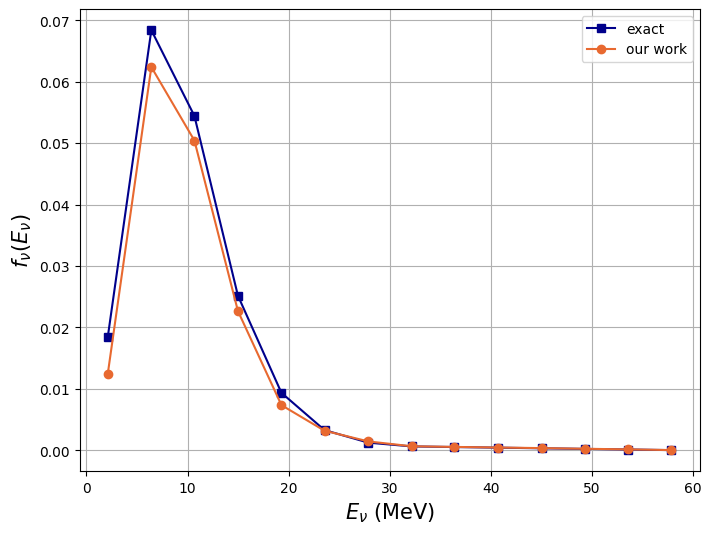

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


data_exact_nue = np.loadtxt('spectrum_nue_exact.txt', delimiter=',')
# data_pinn_nue = I0_nue 

energy = data_exact_nue[:, 0]  # 第一列：能量
f_values_exact_nue = data_exact_nue[:, 1]  # 第二列：f
f_values_pinn_nue = I0_nue

plt.figure(figsize=(8, 6))
plt.plot(energy, f_values_exact_nue, marker='s', color=(0, 0, 139/255),linestyle='-', label='exact')  # 方块标记
plt.plot(energy, f_values_pinn_nue, marker='o', color=(232/255, 105/255, 48/255),linestyle='-', label='our work')  # 方块标记
plt.xlabel(r'$E_\nu$ (MeV)', fontsize=15)
plt.ylabel(r'$f_\nu(E_\nu)$', fontsize=15)
#plt.title(r'Energy vs f($\nu_{e}$) Plot')
plt.grid(True)
plt.legend()
plt.savefig("result_e0412.pdf", format='pdf', bbox_inches='tight')
plt.show()


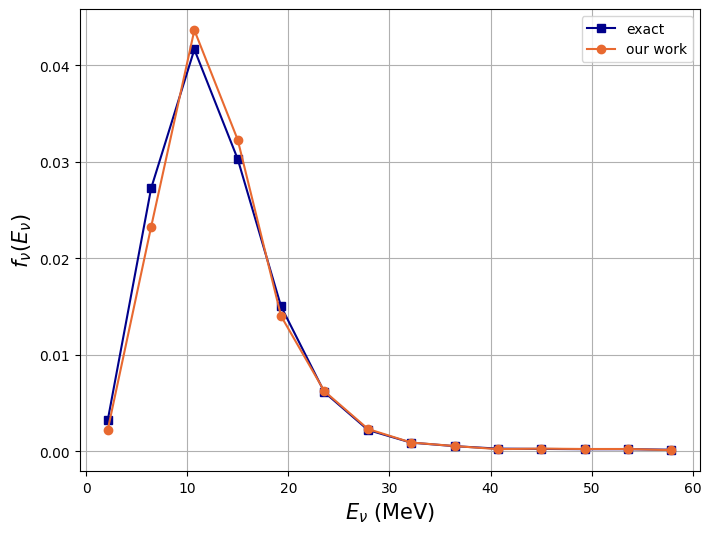

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


data_exact_nueb = np.loadtxt('spectrum_nueb_exact.txt', delimiter=',')


energy = data_exact_nueb[:, 0]  
f_values_exact_nueb = data_exact_nueb[:, 1]  
f_values_pinn_nueb = I0_nueb     

plt.figure(figsize=(8, 6))
plt.plot(energy, f_values_exact_nueb, marker='s',color=(0, 0, 139/255), linestyle='-', label='exact')  
plt.plot(energy, f_values_pinn_nueb, marker='o',color=(232/255, 105/255, 48/255), linestyle='-', label='our work')  
plt.xlabel(r'$E_\nu$ (MeV)', fontsize=15)
plt.ylabel(r'$f_\nu(E_\nu)$', fontsize=15)
#plt.title(r'Energy vs f($\bar{\nu}_{e}$) Plot')
plt.grid(True)
plt.legend()
plt.savefig("result_eb0412.pdf", format='pdf', bbox_inches='tight')
plt.show()


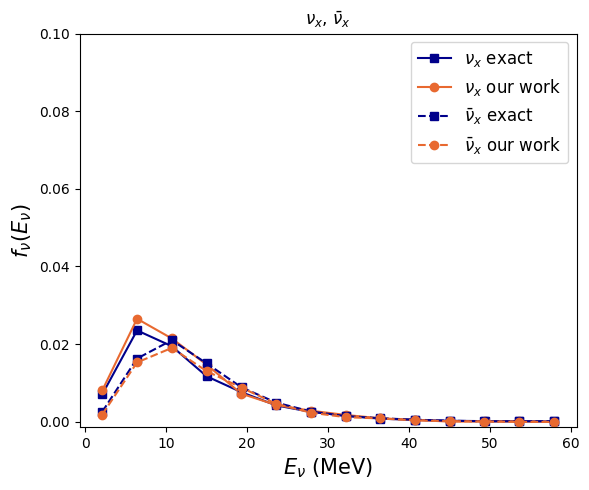

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


data_exact_nuxb = np.loadtxt('spectrum_nuxb_exact.txt', delimiter=',')
energy_nuxb = data_exact_nuxb[:, 0]
f_values_exact_nuxb = data_exact_nuxb[:, 1]
f_values_pinn_nuxb = I0_nuxb

data_exact_nux = np.loadtxt('spectrum_nux_exact.txt', delimiter=',')
energy_nux = data_exact_nux[:, 0]
f_values_exact_nux = data_exact_nux[:, 1]
f_values_pinn_nux = I0_nux


plt.figure(figsize=(6, 5))



plt.plot(energy_nux, f_values_exact_nux, marker='s', color=(0, 0, 139/255), 
         linestyle='-', label=r'$\nu_x$ exact')
plt.plot(energy_nux, f_values_pinn_nux, marker='o', color=(232/255, 105/255, 48/255), 
         linestyle='-', label=r'$\nu_x$ our work')



plt.plot(energy_nuxb, f_values_exact_nuxb, marker='s', color=(0, 0, 139/255), 
         linestyle='--', label=r'$\bar{\nu}_x$ exact')
plt.plot(energy_nuxb, f_values_pinn_nuxb, marker='o', color=(232/255, 105/255, 48/255), 
         linestyle='--', label=r'$\bar{\nu}_x$ our work')


plt.ylim(top=0.1)

plt.title(r'$\nu_x$, $\bar{\nu}_x$')
plt.xlabel(r'$E_\nu$ (MeV)', fontsize=15)
plt.ylabel(r'$f_\nu(E_\nu)$', fontsize=15)

plt.legend(fontsize=12)


plt.tight_layout()
plt.savefig("nux&nuxb.pdf", format='pdf', bbox_inches='tight',dpi=300)
plt.show()

In [ ]:
import numpy as np

def compute_delta_nu(f_exact, f_pinn):
    n_total = np.sum(f_exact)
    delta = np.sum((f_exact / n_total) * np.abs((f_pinn - f_exact) / f_exact))
    return delta


# nue
delta_nue = compute_delta_nu(f_values_exact_nue, f_values_pinn_nue)


# nuebar
delta_nueb = compute_delta_nu(f_values_exact_nueb, f_values_pinn_nueb)


# nux
delta_nux = compute_delta_nu(f_values_exact_nux, f_values_pinn_nux)


# nuxbar
delta_nuxb = compute_delta_nu(f_values_exact_nuxb, f_values_pinn_nuxb)



print(f"δ_nue = {delta_nue:.5e}")
print(f"δ_nueb = {delta_nueb:.5e}")
print(f"δ_nux = {delta_nux:.5e}")
print(f"δ_nuxb = {delta_nuxb:.5e}")


δ_nue = 1.14513e-01
δ_nueb = 8.08408e-02
δ_nux = 1.33192e-01
δ_nuxb = 1.00141e-01


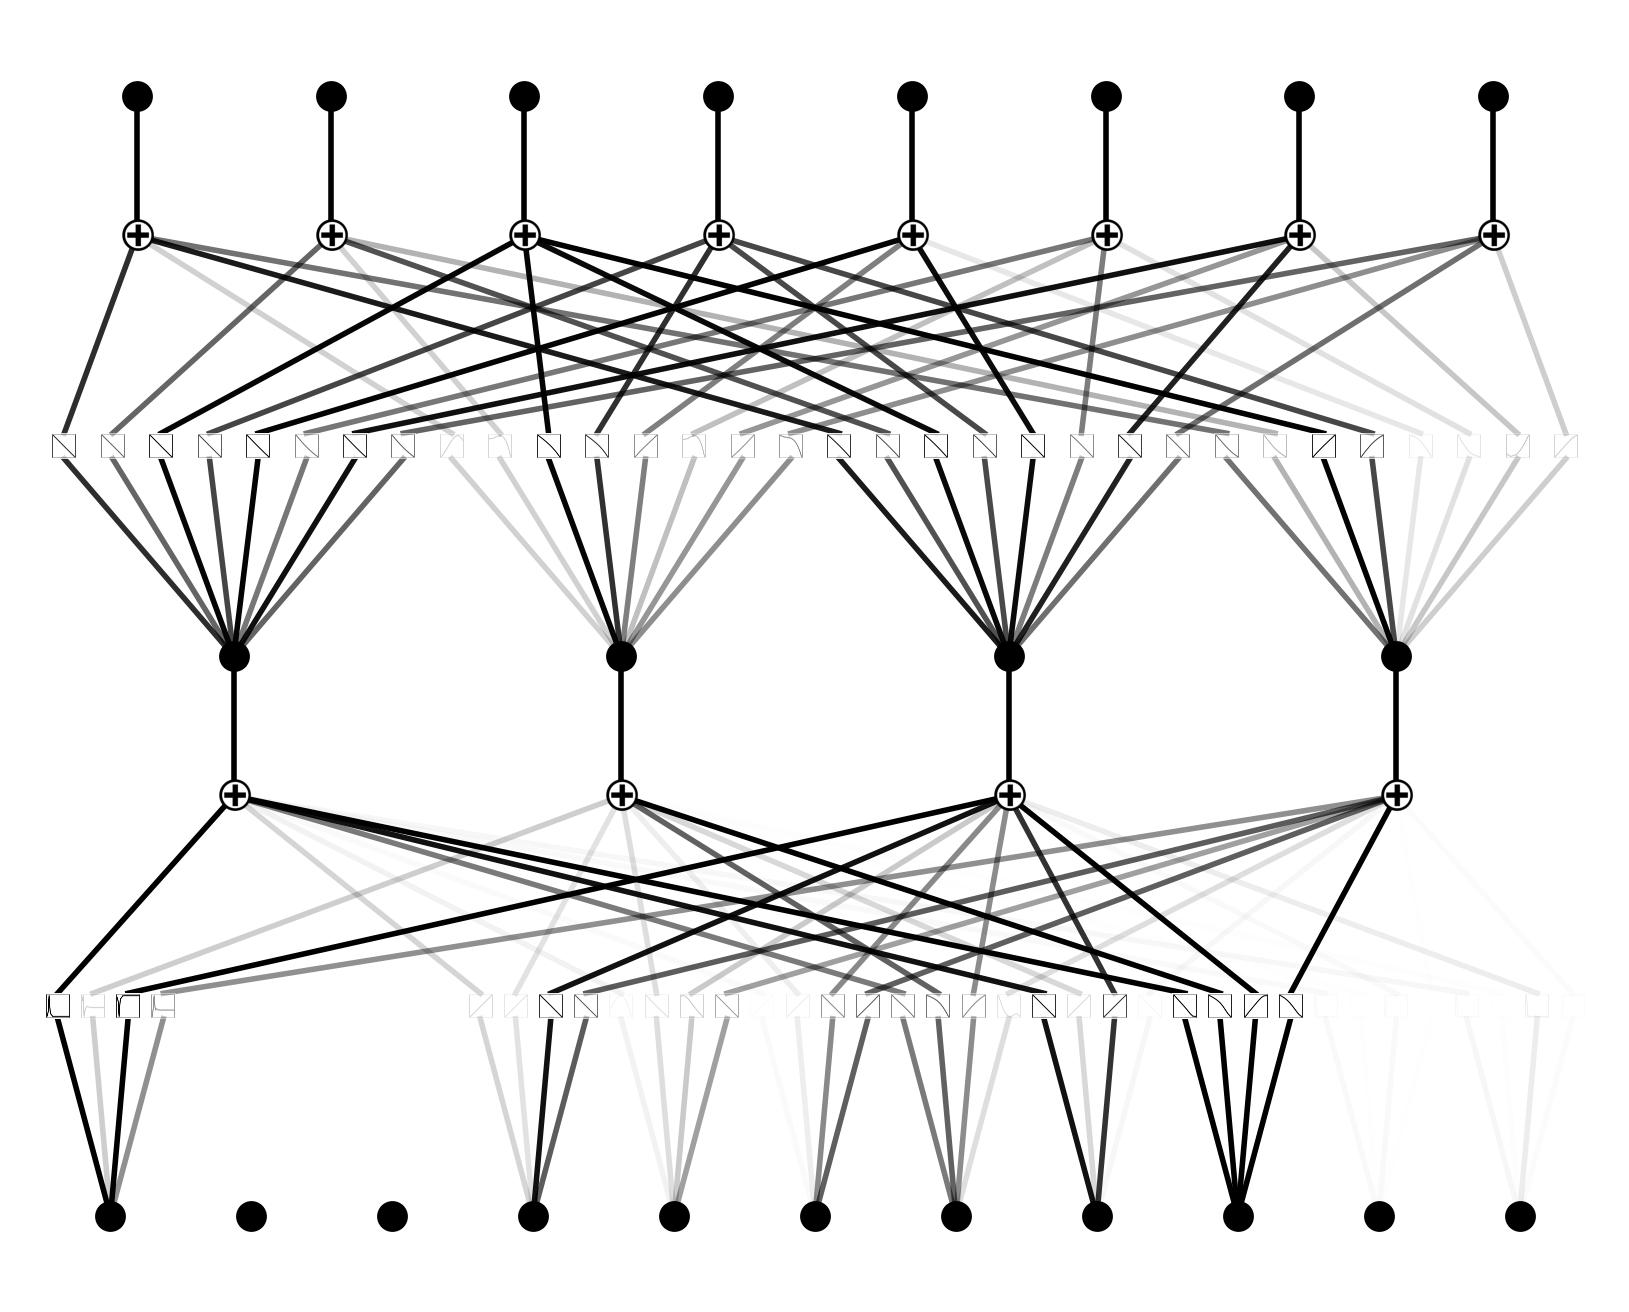

In [35]:
model.output.plot(dpi=400)

In [ ]:
model.output.auto_symbolic(weight_simple=0)

fixing (0,0,0) with tanh, r2=0.9682710271123305, c=3
fixing (0,0,1) with exp, r2=0.9975832710148189, c=2
fixing (0,0,2) with tanh, r2=0.9967318673288621, c=3
fixing (0,0,3) with tanh, r2=0.9908225611191436, c=3
fixing (0,1,0) with x, r2=0.0, c=1
fixing (0,1,1) with x, r2=0.0, c=1
fixing (0,1,2) with x, r2=0.0, c=1
fixing (0,1,3) with x, r2=0.0, c=1
fixing (0,2,0) with 1/x^6, r2=1.0, c=6
fixing (0,2,1) with 1/x^6, r2=1.0, c=6
fixing (0,2,2) with 1/x^6, r2=1.0, c=6
fixing (0,2,3) with 1/x^6, r2=1.0, c=6
fixing (0,3,0) with x^5, r2=0.9999999115914947, c=5
fixing (0,3,1) with x^5, r2=0.9999999090362282, c=5
fixing (0,3,2) with x^5, r2=0.9999998542421777, c=5
fixing (0,3,3) with 1/x^8, r2=0.9999998433429772, c=8
fixing (0,4,0) with x^2, r2=0.9999059334446118, c=2
fixing (0,4,1) with x^1.5, r2=0.9985396799347154, c=4
fixing (0,4,2) with x^1.5, r2=0.9999716028345277, c=4
fixing (0,4,3) with x^4, r2=0.9995091452033257, c=4
fixing (0,5,0) with 1/x^4, r2=0.9999999771580944, c=4
fixing (0,5,1) wi

In [ ]:
from kan.utils import ex_round

ex_round(model.output.symbolic_formula()[0][0],10)

-0.4944558454*(-0.0321759608*(0.8783990373 - x_7)**(3/2) - 0.0208176236*(0.9601824459 - x_9)**2 - 0.1861460844*(1 - 0.0212714521*x_4)**5 + 0.0642231587*(1 - 0.1041419983*x_5)**3 + 0.4951375962*(1 - 0.038326087*x_6)**5 - 0.0013491873*tan(8.8229608536*x_1 + 6.7359199524) - 1 - 0.1065607656/(-0.0628865952*x_8 - 1)**6)**4 - 0.4048375822*(-0.189459279*(1 - 0.0350205786*x_4)**5 + 0.0137740657*(1 - 0.9061571683*x_5)**(3/2) - 0.3677268685*(1 - 0.0191179784*x_6)**5 - 0.0047152933*sin(2.498639822*x_9 + 2.5183200836) - 0.0001338349*tan(0.0559999421*x_7 - 4.8001995087) - 0.0105740198*tanh(3.735519886*x_1 - 7.2163200378) - 1 - 0.0035784061/(-0.1469455076*x_8 - 1)**8)**4 + 21.881445434*(-0.0066684429*(1 - 0.7400828225*x_7)**(3/2) - (-0.0131824468*x_4 - 1)**5 - 0.0351395855*(-0.1121235925*x_6 - 1)**5 + 0.0070055211*exp(0.6090399027*x_5) + 0.0040961589*sin(2.7481598854*x_9 + 5.6200799942) - 0.7670514071 - 0.0267325243/(1 - 0.0625641061*x_8)**7 - 0.0005789433/(1 - 0.5351772117*x_1)**2)**3 - 0.085464045

In [ ]:
model.output.symbolic_formula()

([-0.615056992560065*(-0.0200893907782973*(0.680000019073486 - x_9)**4 + 0.000477618702088946*(1 - 0.594799995422363*x_4)**5 - 0.00604848423523433*(x_5 + 0.619999980926514)**(3/2) - 0.0551455410821233*(-0.0399999618530273*x_6 - 1)**5 - 0.000355483052056858*Abs(10.0*x_7 - 2.19999980926514) + 1 - 0.0159783550342524*exp(-1.19999980926514*x_1) + 0.0511210633551354/(-0.0421324135012278*x_8 - 1)**8 - 2.386216677548e-9/(1 - 0.257856688108375*x_11)**8 - 1.66121974421567e-9/(1 - 0.257763959825443*x_10)**8 - 1.0451556464094e-49/(0.699999988369825 - x_3)**6)**5 + 0.362022861573277*(-0.0324562144717077*(0.993599987030029 - x_7)**(3/2) - 0.0870075331443051*(-0.0461587127192279*x_5 - 1)**4 + 0.0176922604180455*tanh(1.72000002861023*x_1 - 1.39999961853027) - 1 - 0.0404187527421616/(-0.289999988824118*x_9 - 1)**4 - 0.098403802448539/(-0.0408695617491356*x_8 - 1)**8 + 0.369412819905448/(-0.0199999990686765*x_6 - 1)**8 + 0.0445062196029907/(-0.0199999990686765*x_4 - 1)**8 + 1.56649322693968e-8/(1 - 0.25

In [ ]:
ex_round(model.output.symbolic_formula()[0][5],10)

0.1438220919 - 0.0183323358/(0.0014433306*(1 - 0.9617720566*x_4)**4 + 0.0001114625*(1 - 0.177854661*x_5)**4 + 0.0006729039*(1 - 0.9961293043*x_9)**(3/2) - 1.1838e-6*tan(6.5892796516*x_7 - 4.1960000992) - 1 - 0.0035166616/(-0.965972283*x_6 - 1)**4 + 9.1553e-6/(0.6752112137 - x_8)**8 - 1.354e-7/(0.3260299089 - x_1)**4)**8 + 0.0086412558/(0.0018474188*(0.4063999653 - x_5)**3 + 0.0051820928*(0.5086159857 - x_7)**4 + 4.59044e-5*tan(0.2319997847*x_1 + 1.375279665) - 0.0002221831*Abs(10.0*x_9 - 9.5279998779) - 1 - 0.0247997212/(-0.8886619402*x_8 - 1)**6 + 0.0013390224/(-0.8027268771*x_4 - 1)**6 + 0.0085994211/(1 - 0.0519159472*x_6)**5)**8 - 0.1313704755/(0.0023287868*(1 - 0.406334914*x_4)**4 - 0.0002432397*(1 - 0.9200220914*x_9)**(3/2) + 2.9314e-6*tan(0.2479997724*x_1 + 1.3569597006) - 6.2e-9*tan(0.0006399993*x_5 + 1.5710397959) - 1.556e-7*tan(0.4079996347*x_7 - 5.0445599556) - 1 - 1.8534e-5/(-x_8 - 0.6612851386)**8)**8